<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection-Projects/blob/main/h3_Titanic_Survival_Prediction__clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kaggle Titanic Survival Prediction Project 
[Source](https://www.kaggle.com/c/titanic/data)

In [1]:
import os
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn import impute
from sklearn import decomposition
from sklearn import ensemble
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection

#Step 1: Read Data and Understand It 

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle competitions download -c titanic
!unzip \*.zip && rm *.zip

In [6]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv('test.csv')
sub_data = pd.read_csv('gender_submission.csv')

In [7]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
"""
PassengerId: (int) : index + 1,                        Not important at all.
Survived: (int): (Target)  , Very Important.
Pclass: (int):(CATEGORICAL), Ticket Class , Important
1st = Upper
2nd = Middle
3rd = Lower,

Name: (str):                                           Not important at all.
Sex: (str): (CATEGORICAL),  important.
Age: (float): important
SibSp: (int): (CATEGORICAL), number("#") of siblings / spouses aboard the Titanic	, important.

Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

Parch: (int): (CATEGORICAL), number('#') of parents / children aboard the Titanic	, important.
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Ticket: (str):                                       maybe Not important at all.
Fare: (float): Important
Cabin: (str): (CATEGORICAL), Cabin number	 maybe important.
Embarked: (str): (CATEGORICAL), Port of Embarkation (بندر سوار شدن) important.
"""

#Step 2: Data Cleaning and Preprations

In [9]:
test_data.columns
sub_data.columns
train_data.columns, len(train_data)

(Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
       dtype='object'), 891)

In [10]:
train_data[train_data.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


##Missing Data Count & Percentage

In [11]:
null_df = pd.DataFrame([np.int64(np.sum(test_data.isnull())), round(np.sum(test_data.isnull()) * 100 / len(test_data), 2)]).T
null_df.index = test_data.columns
null_df.columns = ['count', 'percent']
null_df

,count,percent
PassengerId,0.0,0.00
Pclass,0.0,0.00
Name,0.0,0.00
Sex,0.0,0.00
Age,86.0,20.57
SibSp,0.0,0.00
Parch,0.0,0.00
Ticket,0.0,0.00
Fare,1.0,0.24
Cabin,327.0,78.23


In [12]:
null_df = pd.DataFrame([np.int64(np.sum(train_data.isnull())), round(np.sum(train_data.isnull()) * 100 / len(train_data), 2)]).T
null_df.index = train_data.columns
null_df.columns = ['count', 'percent']
null_df

,count,percent
PassengerId,0.0,0.00
Survived,0.0,0.00
Pclass,0.0,0.00
Name,0.0,0.00
Sex,0.0,0.00
Age,177.0,19.87
SibSp,0.0,0.00
Parch,0.0,0.00
Ticket,0.0,0.00
Fare,0.0,0.00


In [13]:
# because Embarked has only 2 missing values, I replace it with the most common one.
train_data["Embarked"].fillna('S', inplace=True)

In [14]:
# because Fare has only one missing value, I replaced it with the mean of the Fare data.
test_data['Fare'].fillna(test_data.Fare.mean(), inplace=True)

In [15]:
# X.Age.describe()
train_data['Age'].fillna(np.int64(train_data.Age.mean()), inplace=True)
test_data['Age'].fillna(np.int64(test_data.Age.mean()), inplace=True)

In [17]:
# Cabin's 77% of the data is null, so it is useless
train_data.drop(columns=["PassengerId", "Name", "Ticket", 'Cabin'], inplace=True)
test_data.drop(columns=["Name", "Ticket", 'Cabin'], inplace=True)

In [18]:
X = train_data.drop(columns=['Survived'])
Y = train_data.Survived

##One Hot Encoded Data VS Label Encoded Data

In [19]:
one_x = X.copy() 
le_x = X.copy()
test = test_data.copy()
def oneHotEncoder_function(df, c):
  one = preprocessing.OneHotEncoder(sparse=False, dtype=np.int64)
  temp = one.fit_transform(pd.DataFrame(df[c]))
  df = pd.concat([df, pd.DataFrame(temp, columns=one.categories_[0])], axis=1)
  df.drop(columns=[c], inplace=True)
  return df

def labelEncoder_function(df):
  """
  Sex ['female'=0,    'male'=1]
  Embarked ['C'=0,  'Q'=1,    'S'=2]
  """
  le = preprocessing.LabelEncoder()
  for c in ['Sex', "Embarked"]:
    df[c] = le.fit_transform(df[c])
    print(c, le.classes_)
  return df  

test = oneHotEncoder_function(test, 'Sex')
test = oneHotEncoder_function(test, 'Embarked')

one_x = oneHotEncoder_function(one_x, 'Sex')
one_x = oneHotEncoder_function(one_x, 'Embarked')

le_x = labelEncoder_function(le_x)

Sex ['female' 'male']
Embarked ['C' 'Q' 'S']


#Step 3: Data Visualizing

##Target Visualization

In [20]:
Y.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

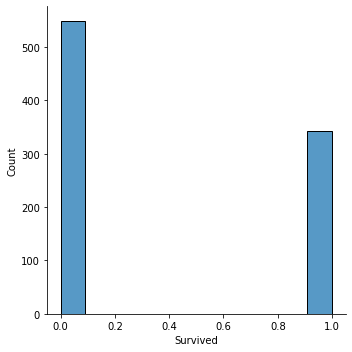

In [21]:
sns.displot(Y)

In [22]:
y_1 = 100 * sum(Y>=1) / len(Y)
y_0 = 100 - y_1
print(f"""The Target contains % {y_1} one value and % {y_0} zero value""")
#So more than half of the people in the Titanic couldn't survive

The Target contains % 38.38383838383838 one value and % 61.61616161616162 zero value


##Features Data Visualization

In [23]:
categorical_data = ["Sex", 'Embarked', "Pclass", "SibSp", "Parch"]
le_x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
4,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...
886,2,1,27.0,0,0,13.0000,2
887,1,0,19.0,0,0,30.0000,2
888,3,0,29.0,1,2,23.4500,2
889,1,1,26.0,0,0,30.0000,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


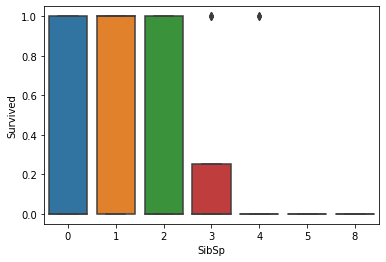

In [34]:
sns.boxplot(X['SibSp'], Y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


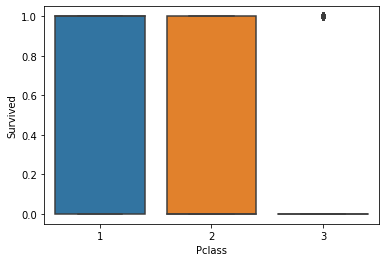

In [28]:
sns.boxplot(X['Pclass'], Y)

#Step 4: Data Preprocessing

In [31]:
le_data = pd.concat([le_x, Y], axis=1)
one_data = pd.concat([one_x, Y], axis=1)

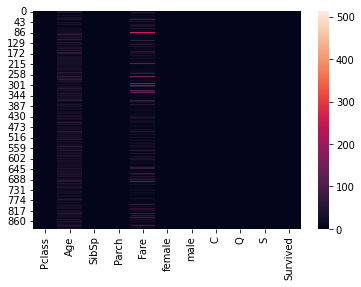

In [33]:
sns.heatmap(one_data)

In [35]:
one_x.drop(columns=['male', 'Q', 'S'], inplace=True)
test.drop(columns=['male', 'Q', 'S'], inplace=True)

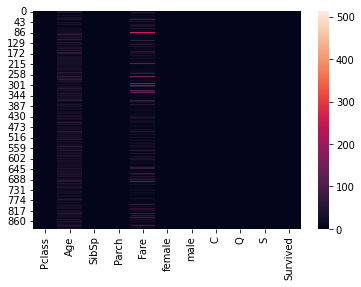

In [37]:
sns.heatmap(one_data)

In [38]:
standard_scaler = preprocessing.StandardScaler()
minmax_scaler = preprocessing.MinMaxScaler()
normalizer = preprocessing.Normalizer()

le_x_standard = standard_scaler.fit_transform(le_x)
le_x_minmax = minmax_scaler.fit_transform(le_x)
le_x_normalizer = normalizer.fit_transform(le_x)


one_x_standard = standard_scaler.fit_transform(one_x)
one_x_minmax = minmax_scaler.fit_transform(one_x)
one_x_normalizer = normalizer.fit_transform(one_x)

In [39]:
np.random.seed(34)
train_xl, test_xl, train_yl, test_yl = model_selection.train_test_split(le_x, Y, test_size=0.2, random_state=52)
train_xo, test_xo, train_yo, test_yo = model_selection.train_test_split(one_x, Y, test_size=0.2, random_state=52)

train_xos, test_xos, train_yos, test_yos = model_selection.train_test_split(one_x_standard, Y, test_size=0.2, random_state=52)
train_xom, test_xom, train_yom, test_yom = model_selection.train_test_split(one_x_minmax, Y, test_size=0.2, random_state=52)
train_xon, test_xon, train_yon, test_yon = model_selection.train_test_split(one_x_normalizer, Y, test_size=0.2, random_state=52)

train_xls, test_xls, train_yls, test_yls = model_selection.train_test_split(le_x_standard, Y, test_size=0.2, random_state=52)
train_xlm, test_xlm, train_ylm, test_ylm = model_selection.train_test_split(le_x_minmax, Y, test_size=0.2, random_state=52)
train_xln, test_xln, train_yln, test_yln = model_selection.train_test_split(le_x_normalizer, Y, test_size=0.2, random_state=52)

#Step 5: Model Selection

at first with the Pure data

In [ ]:
x_train, x_test, y_train, test_y = train_xo, test_xo, train_yo, test_yo
# train_xl, test_xl, train_yl, test_yl
# train_xos, test_xos, train_yos, test_yos
# train_xom, test_xom, train_yom, test_yom
# train_xon, test_xon, train_yon, test_yon
# train_xls, test_xls, train_yls, test_yls
# train_xlm, test_xlm, train_ylm, test_ylm
# train_xln, test_xln, train_yln, test_yln

In [ ]:
model1 = linear_model.LogisticRegressionCV()
model1.fit(x_train, y_train)
pred1=model1.predict(x_test)
acc_1=metrics.accuracy_score(test_y, pred1)
# model_selection.cross_val_score()
acc_1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.8044692737430168

In [ ]:
model2 = linear_model.RidgeClassifierCV()
model2.fit(x_train, y_train)
pred2=model2.predict(x_test)
acc_2=metrics.accuracy_score(test_y, pred2)
acc_2

0.8100558659217877

In [ ]:
model3 = linear_model.SGDClassifier()
model3.fit(x_train, y_train)
pred3=model3.predict(x_test)
acc_3=metrics.accuracy_score(test_y, pred3)
acc_3

0.7486033519553073

In [ ]:
model4 = neighbors.KNeighborsClassifier()
model4.fit(x_train, y_train)
pred4=model4.predict(x_test)
acc_4=metrics.accuracy_score(test_y, pred4)
acc_4

0.6815642458100558

In [ ]:
model5 = svm.LinearSVC()
model5.fit(x_train, y_train)
pred5=model5.predict(x_test)
acc_5=metrics.accuracy_score(test_y, pred5)
acc_5

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6871508379888268

In [ ]:
model6 = svm.SVC()
model6.fit(x_train, y_train)
pred6=model6.predict(x_test)
acc_6=metrics.accuracy_score(test_y, pred6)
acc_6

0.6536312849162011

In [ ]:
model7 = svm.NuSVC()
model7.fit(x_train, y_train)
pred7=model7.predict(x_test)
acc_7=metrics.accuracy_score(test_y, pred7)
acc_7

0.7988826815642458

In [ ]:
model8 = tree.DecisionTreeClassifier()
model8.fit(x_train, y_train)
pred8=model8.predict(x_test)
acc_8=metrics.accuracy_score(test_y, pred8)
acc_8

0.7597765363128491

In [ ]:
model9 = tree.ExtraTreeClassifier()
model9.fit(x_train, y_train)
pred9=model9.predict(x_test)
acc_9=metrics.accuracy_score(test_y, pred9)
acc_9

0.776536312849162

In [ ]:
model10 = ensemble.AdaBoostClassifier()
model10.fit(x_train, y_train)
pred10=model10.predict(x_test)
acc_10=metrics.accuracy_score(test_y, pred10)
acc_10

0.8268156424581006

In [ ]:
model11 = ensemble.BaggingClassifier()
model11.fit(x_train, y_train)
pred11=model11.predict(x_test)
acc_11=metrics.accuracy_score(test_y, pred11)
acc_11

0.8044692737430168

In [ ]:
model12 = ensemble.ExtraTreesClassifier()
model12.fit(x_train, y_train)
pred12=model12.predict(x_test)
acc_12=metrics.accuracy_score(test_y, pred12)
acc_12

0.7932960893854749

In [ ]:
model13 = ensemble.GradientBoostingClassifier()
model13.fit(x_train, y_train)
pred13=model13.predict(x_test)
acc_13=metrics.accuracy_score(test_y, pred13)
acc_13

0.8603351955307262

In [ ]:
model14 = ensemble.RandomForestClassifier()
model14.fit(x_train, y_train)
pred14=model14.predict(x_test)
acc_14=metrics.accuracy_score(test_y, pred14)
acc_14

0.8100558659217877

In [ ]:
model15 = xgboost.XGBClassifier()
model15.fit(x_train, y_train)
pred15=model15.predict(x_test)
acc_15=metrics.accuracy_score(test_y, pred15)
acc_15

0.8379888268156425

In [ ]:
model16 = xgboost.XGBRFClassifier()
model16.fit(x_train, y_train)
pred16=model16.predict(x_test)
acc_16=metrics.accuracy_score(test_y, pred16)
acc_16

0.8044692737430168

In [ ]:
def model_selection_func(x_train, y_train):
    model1 = linear_model.LogisticRegressionCV()
    model1.fit(x_train, y_train)
    pred1=model1.predict(x_test)
    acc_1=metrics.accuracy_score(test_y, pred1)
    model2 = linear_model.RidgeClassifierCV()
    model2.fit(x_train, y_train)
    pred2=model2.predict(x_test)
    acc_2=metrics.accuracy_score(test_y, pred2)
    model3 = linear_model.SGDClassifier()
    model3.fit(x_train, y_train)
    pred3=model3.predict(x_test)
    acc_3=metrics.accuracy_score(test_y, pred3)
    model4 = neighbors.KNeighborsClassifier()
    model4.fit(x_train, y_train)
    pred4=model4.predict(x_test)
    acc_4=metrics.accuracy_score(test_y, pred4)
    model5 = svm.LinearSVC()
    model5.fit(x_train, y_train)
    pred5=model5.predict(x_test)
    acc_5=metrics.accuracy_score(test_y, pred5)
    model6 = svm.SVC()
    model6.fit(x_train, y_train)
    pred6=model6.predict(x_test)
    acc_6=metrics.accuracy_score(test_y, pred6)
    model7 = svm.NuSVC()
    model7.fit(x_train, y_train)
    pred7=model7.predict(x_test)
    acc_7=metrics.accuracy_score(test_y, pred7)
    model8 = tree.DecisionTreeClassifier()
    model8.fit(x_train, y_train)
    pred8=model8.predict(x_test)
    acc_8=metrics.accuracy_score(test_y, pred8)
    model9 = tree.ExtraTreeClassifier()
    model9.fit(x_train, y_train)
    pred9=model9.predict(x_test)
    acc_9=metrics.accuracy_score(test_y, pred9)
    model10 = ensemble.AdaBoostClassifier()
    model10.fit(x_train, y_train)
    pred10=model10.predict(x_test)
    acc_10=metrics.accuracy_score(test_y, pred10)
    model11 = ensemble.BaggingClassifier()
    model11.fit(x_train, y_train)
    pred11=model11.predict(x_test)
    acc_11=metrics.accuracy_score(test_y, pred11)
    model12 = ensemble.ExtraTreesClassifier()
    model12.fit(x_train, y_train)
    pred12=model12.predict(x_test)
    acc_12=metrics.accuracy_score(test_y, pred12)
    model13 = ensemble.GradientBoostingClassifier()
    model13.fit(x_train, y_train)
    pred13=model13.predict(x_test)
    acc_13=metrics.accuracy_score(test_y, pred13)
    model14 = ensemble.RandomForestClassifier()
    model14.fit(x_train, y_train)
    pred14=model14.predict(x_test)
    acc_14=metrics.accuracy_score(test_y, pred14)


    val_score_1=model_selection.cross_val_score(model1, x_train, y_train),
    val_score_2=model_selection.cross_val_score(model2, x_train, y_train),
    val_score_3=model_selection.cross_val_score(model3, x_train, y_train),
    val_score_4=model_selection.cross_val_score(model4, x_train, y_train),
    val_score_5=model_selection.cross_val_score(model5, x_train, y_train),
    val_score_6=model_selection.cross_val_score(model6, x_train, y_train),
    val_score_7=model_selection.cross_val_score(model7, x_train, y_train),
    val_score_8=model_selection.cross_val_score(model8, x_train, y_train),
    val_score_9=model_selection.cross_val_score(model9, x_train, y_train),
    val_score_10=model_selection.cross_val_score(model10, x_train, y_train),
    val_score_11=model_selection.cross_val_score(model11, x_train, y_train),
    val_score_12=model_selection.cross_val_score(model12, x_train, y_train),
    val_score_13=model_selection.cross_val_score(model13, x_train, y_train),
    val_score_14=model_selection.cross_val_score(model14, x_train, y_train),


    acc_dff = {
        'model_1': acc_1,
        'model_2': acc_2,
        'model_3': acc_3,
        'model_4': acc_4,
        'model_5': acc_5,
        'model_6': acc_6,
        'model_7': acc_7,
        'model_8': acc_8,
        'model_9': acc_9,
        'model_10': acc_10,
        'model_11': acc_11,
        'model_12': acc_12,
        'model_13': acc_13,
        'model_14': acc_14,
    }

    val_score_dff = {
        'model_1': np.mean(val_score_1),
        'model_2': np.mean(val_score_2),
        'model_3': np.mean(val_score_3),
        'model_4': np.mean(val_score_4),
        'model_5': np.mean(val_score_5),
        'model_6': np.mean(val_score_6),
        'model_7': np.mean(val_score_7),
        'model_8': np.mean(val_score_8),
        'model_9': np.mean(val_score_9),
        'model_10': np.mean(val_score_10),
        'model_11': np.mean(val_score_11),
        'model_12': np.mean(val_score_12),
        'model_13': np.mean(val_score_13),
        'model_14': np.mean(val_score_14),
    }
    return acc_dff, val_score_dff

In [ ]:
data_groups = [[train_xl, train_yl], [train_xo, train_yo], [train_xos, train_yos], [train_xom, train_yom], 
               [train_xon, train_yon], [train_xls, train_yls], [train_xlm, train_ylm], [train_xln, train_yln]]

all_acc_df = pd.DataFrame()
all_val_score_df = pd.DataFrame()

for i, g in enumerate(data_groups):
  acc, val_score = model_selection_func(g[0], g[1])
  all_acc_df[i] = acc.values()
  all_val_score_df[i] = val_score.values()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

In [ ]:
all_val_score_df
# .describe()
# .mean(axis=1).sort_values(ascending=False)

,0,1,2,3,4,5,6,7
0,0.792140,0.786516,0.789333,0.780922,0.780951,0.785157,0.790781,0.766867
1,0.789333,0.790742,0.792140,0.787925,0.740274,0.790742,0.792130,0.723382
2,0.639043,0.627736,0.735822,0.740185,0.716360,0.748715,0.744381,0.654378
3,0.700827,0.693795,0.790811,0.786585,0.723274,0.797823,0.787994,0.716261
4,0.651699,0.761194,0.785137,0.789343,0.700926,0.785137,0.786536,0.693884
5,0.682596,0.682596,0.810391,0.787984,0.689717,0.806215,0.797794,0.689707
6,0.783699,0.785098,0.818802,0.792130,0.787925,0.811790,0.796307,0.783719
7,0.743071,0.744499,0.747296,0.740284,0.758436,0.738836,0.745898,0.723372
8,0.762691,0.747168,0.765478,0.762681,0.744420,0.741603,0.738777,0.737358
9,0.775318,0.779543,0.780951,0.779543,0.762661,0.776726,0.775318,0.766847


In [ ]:
all_acc_df
# .mean(axis=1).sort_values(ascending=False)

,0,1,2,3,4,5,6,7
0,0.631285,0.804469,0.642458,0.670391,0.754190,0.631285,0.631285,0.631285
1,0.631285,0.810056,0.642458,0.653631,0.748603,0.631285,0.631285,0.631285
2,0.631285,0.631285,0.653631,0.653631,0.726257,0.631285,0.631285,0.631285
3,0.363128,0.681564,0.608939,0.642458,0.720670,0.631285,0.631285,0.391061
4,0.631285,0.620112,0.636872,0.659218,0.631285,0.631285,0.631285,0.631285
5,0.642458,0.653631,0.631285,0.631285,0.631285,0.631285,0.631285,0.631285
6,0.648045,0.798883,0.631285,0.631285,0.631285,0.631285,0.631285,0.368715
7,0.363128,0.793296,0.731844,0.731844,0.636872,0.631285,0.363128,0.748603
8,0.625698,0.759777,0.402235,0.737430,0.363128,0.385475,0.620112,0.391061
9,0.424581,0.826816,0.396648,0.391061,0.558659,0.597765,0.340782,0.368715


In [ ]:
all_val_score_df.mean(axis=0).sort_values(ascending=False)

2    0.782926
5    0.782046
6    0.781834
3    0.777929
1    0.752918
4    0.751344
0    0.748921
7    0.740589
dtype: float64

In [ ]:
all_acc_df.mean(axis=0).sort_values(ascending=False)

1    0.760974
5    0.610535
2    0.607741
3    0.604549
4    0.573025
6    0.547087
0    0.529130
7    0.506385
dtype: float64

In [ ]:
model15 = xgboost.XGBClassifier()
model15.fit(x_train, y_train)
pred15=model15.predict(x_test)
acc_15=metrics.accuracy_score(test_y, pred15)
model16 = xgboost.XGBRFClassifier()
model16.fit(x_train, y_train)
pred16=model16.predict(x_test)
acc_16=metrics.accuracy_score(test_y, pred16)
acc_15, acc_16

(0.8379888268156425, 0.8044692737430168)

#Step 6: Final Model Selection
## Model13: ensemble.GradientBoostingClassifier()

## Model15: xgboost.XGBClassifier()


In [ ]:
m1 = ensemble.GradientBoostingClassifier()
m2 = xgboost.XGBClassifier()

In [ ]:
# x_train, x_test, y_train, y_test =  train_xo, test_xo, train_yo, test_yo
# x_train, x_test, y_train, y_test =  train_xl, test_xl, train_yl, test_yl
# x_train, x_test, y_train, y_test =  train_xos, test_xos, train_yos, test_yos
# x_train, x_test, y_train, y_test =  train_xom, test_xom, train_yom, test_yom
# x_train, x_test, y_train, y_test =  train_xon, test_xon, train_yon, test_yon
# x_train, x_test, y_train, y_test =  train_xls, test_xls, train_yls, test_yls
# x_train, x_test, y_train, y_test =  train_xlm, test_xlm, train_ylm, test_ylm
x_train, x_test, y_train, y_test =  train_xln, test_xln, train_yln, test_yln
m1.fit(x_train, y_train)
p1=m1.predict(x_test)
a1=metrics.accuracy_score(y_test, p1)
m2.fit(x_train, y_train)
p2=m2.predict(x_test)
a2=metrics.accuracy_score(y_test, p2)
print(metrics.classification_report(y_test, p1))
print(metrics.classification_report(y_test, p2))
a1, a2

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       113
           1       0.75      0.71      0.73        66

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       113
           1       0.77      0.73      0.75        66

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



(0.8044692737430168, 0.8212290502793296)

#Tunnig the final data and final model

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(one_x, Y, test_size=0.01)
# train_xo, test_xo, train_yo, test_yo
model = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
model.fit(x_train, y_train)
pred=model.predict(x_test)
a1=metrics.accuracy_score(y_test, pred)
print(metrics.classification_report(y_test, pred))
a1

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.00      0.00      0.00         0

    accuracy                           0.67         9
   macro avg       0.50      0.33      0.40         9
weighted avg       1.00      0.67      0.80         9



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6666666666666666

In [ ]:
# print(one_x.shape[0]/100)
# params = {'learning_rate': [0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.001, 0.0001, 0.01, 0.000001],
#           'scoring' : ['accuracy', 'precision','recall'],
#           "max_features":["log2","sqrt"],
#           'n_estimators': [5,10,15,20, 30, 40, 50, 60, 70, 80, 90, 100]}
# res=model_selection.GridSearchCV(model, param_grid=params, scoring='accuracy')
# res.score()
# res.fit(x_train, y_train)
# # res.best_params
# # dpp.model_parameters_chooser(x_train, y_train, model, reg=False, hints=False, score_choice=0, sf_choice=1)
param_grid = { 
    'n_estimators': [20,30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.001, 0.0001, 0.01, 0.000001],
    # 'scoring' : ['accuracy', 'precision','recall'],
    "max_features":["log2","sqrt"],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6, 7, 8, 9, 10, 11,12, 13, 14, 15, 16, 17, 18, 19,20, 21, 22,23,24, 25,26,27,28,29,30, 50],
}
                
# , refit = True, verbose = 3, n_jobs=-1, cv= 5                
grid = model_selection.GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(x_train, y_train)
grid.best_params_

In [ ]:
best_score=0
for i in range(100):
  clf = ensemble.GradientBoostingClassifier(learning_rate=0.1, n_estimators=np.random.randint(100, 1001))
  clf.fit(x_train, y_train)
  predd = clf.predict(x_test)
  score=metrics.accuracy_score(y_test, predd)
  if score > best_score:
    best_score=score
    model = clf
    print(best_score)

0.6666666666666666
0.7777777777777778


In [ ]:
param_grid = param_grid = { 
    'n_estimators': [20,30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth' : [6, 7, 8, 9, 10, 11,12, 13, 14, 15, 16, 17, 18, 19,20, 21, 22,23,24, 25,26,27,28,29,30, 50],
}
grid = model_selection.GridSearchCV(estimator=model, cv=5,param_grid=param_grid)
grid.fit(one_x, Y)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(n_estimators=277),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                                       27, 28, 29, 30, 50],
                         'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100]})

In [ ]:
grid.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_depth=6)

In [ ]:
pred = grid.predict(test.drop(columns=['PassengerId']))
sub_data['Survived'] = pred.astype(int)
sub_data.to_csv('submission.csv', index = False)

In [ ]:
import pickle

# pickle.dump(model, open("/content/drive/MyDrive/Colab Notebooks/Heoku_projects/h3_best_model.sav", "wb"))
loadm = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Heoku_projects/h3_best_model.sav", "rb"))
loadm.fit(x_train, y_train)
loadpred = loadm.predict(x_test)
metrics.accuracy_score(y_test, loadpred)
# list(zip(loadpred, y_test))
# pickle.dump(loadm, open("/content/drive/MyDrive/Colab Notebooks/Heoku_projects/h2_all_best_model.sav", "wb"))

0.8888888888888888

In [ ]:
loadm.fit(le_x, Y)
le = preprocessing.LabelEncoder()
for l in test_data.columns[1:]:
  test_data[l] = le.fit_transform(test_data[l])

In [ ]:
p = loadm.predict(test_data[test_data.columns[1:]])
metrics.accuracy_score(sub_data.Survived, p)

0.9114832535885168

In [ ]:
# inputs = [Pclass, Sex, Age, SibSp, Parch, Fare, Embarked]
# inputs = [Pclass=2, Sex=1 Age=23, SibSp=0, Parch=1, Fare=23, Embarked=1]
  # """
  # Sex ['female'=0,    'male'=1]
  # Embarked ['C'=0,  'Q'=1,    'S'=2]
  # """
inputs = np.array([2, 1, 23,43,4, 4, 1]).reshape(-1, 1)
loadm.predict(inputs.T)

array([0])

In [ ]:
test = test_data[test_data.columns[1:]].values
train = le_x.astype(np.int64).values
all_data_x = np.concatenate([train, test])
all_data_y = np.concatenate([Y, sub_data.Survived.values])

loadm.fit(all_data_x, all_data_y)

# pickle.dump(loadm, open("/content/drive/MyDrive/Colab Notebooks/Heoku_projects/h3_best_model.sav", "wb"))